In [181]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib
import warnings
warnings.filterwarnings('ignore')

card_df = pd.read_csv("data/creditcard.csv")
print('dataset shape:', card_df.shape)
card_df.head(3)

dataset shape: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


타겟 : Class 속성 0 정상, 1 사기 거래
클래스의 분포 확인 > 0.1%
Time : second, 각 거래와 이전 거래 사이의 경과 시간
Amount : 거래 금액



# 언더 샘플링, 오버 샘플링
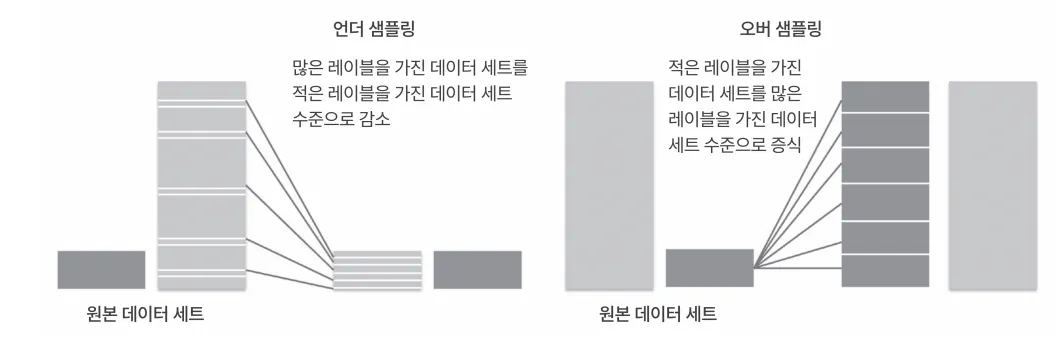

## 전처리 함수 get_preprocessed_df()

In [182]:
from sklearn.model_selection import train_test_split

# 인자로 입력받은 DataFrame을 복사 한 뒤 Time 컬럼만 삭제하고 복사된 DataFrame 반환
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    df_copy.drop('Time', axis=1, inplace=True)

    
    return df_copy

In [183]:
# 사전 데이터 가공 후 학습과 테스트 데이터 세트를 반환하는 함수.
def get_train_test_dataset(df=None):
    # 인자로 입력된 DataFrame의 사전 데이터 가공이 완료된 복사 DataFrame 반환
    df_copy = get_preprocessed_df(df)
    # DataFrame의 맨 마지막 컬럼이 레이블, 나머지는 피처들
    X_features = df_copy.iloc[:, :-1]
    y_target = df_copy.iloc[:, -1]
    # train_test_split( )으로 학습과 테스트 데이터 분할. stratify=y_target으로 Stratified 기반 분할
    X_train, X_test, y_train, y_test = \
    train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)
    # 학습과 테스트 데이터 세트 반환
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

# 분포 확인


In [184]:
print(f'학습데이터의 사기거래 비율은 : {y_train.value_counts()/y_train.shape[0]*100}')
print(f'테스트데이터의 사기거래 비율은 : {y_test.value_counts()/y_test.shape[0]*100}')

학습데이터의 사기거래 비율은 : 0    99.827451
1     0.172549
Name: Class, dtype: float64
테스트데이터의 사기거래 비율은 : 0    99.826785
1     0.173215
Name: Class, dtype: float64


## 평가함수

In [185]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

### 원본 데이터 가공X, LR,LGBM 비교

In [186]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
lr_pred_proba = lr_clf.predict_proba(X_test)[:,1]
get_clf_eval(y_test, lr_pred, lr_pred_proba)

from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

오차 행렬
[[85282    13]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8738, 재현율: 0.6081,    F1: 0.7171, AUC:0.9605
오차 행렬
[[85290     5]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9573, 재현율: 0.7568,    F1: 0.8453, AUC:0.9790


# 피처 특성을 파악, 전처리

1. Amount 피처

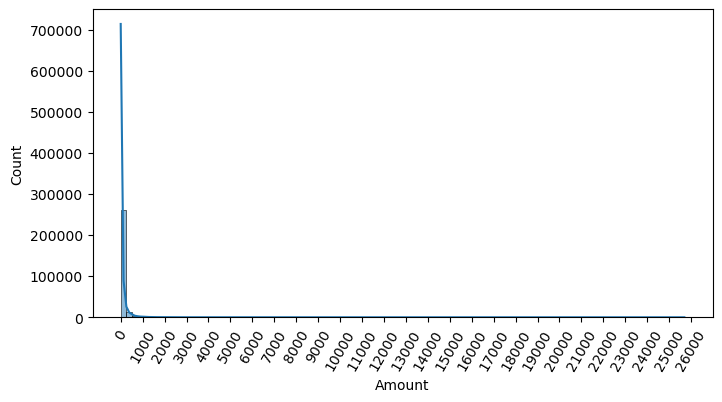

In [187]:
import seaborn as sns

plt.figure(figsize=(8,4))
plt.xticks(range(0,30000,1000), rotation=60)
sns.histplot(card_df['Amount'], bins=100, kde=True)
plt.show()

# get_preprocessed_df() 스케일러 추가

Amount 피처를 정규 분포 형태로 변환

In [188]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 인자로 입력받은 DataFrame을 복사 한 뒤 Time 컬럼만 삭제하고 복사된 DataFrame 반환

def get_preprocessed_df(df=None):
    df_copy = df.copy()
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1,1))

    df_copy.insert(0, 'Amount_scaled', amount_n)
    
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    
    return df_copy

In [189]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, X_train,X_test, y_train, y_test )

from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

오차 행렬
[[85281    14]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8654, 재현율: 0.6081,    F1: 0.7143, AUC:0.9702
오차 행렬
[[85290     5]
 [   37   111]]
정확도: 0.9995, 정밀도: 0.9569, 재현율: 0.7500,    F1: 0.8409, AUC:0.9779


### StandardScaler - > 로그 변환

In [190]:
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    df_copy.drop('Time', axis=1, inplace=True)
    
    #Amount scaling
    scaler = StandardScaler()
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_scaled', amount_n)
    df_copy.drop(['Time','Amount'], axis=1, inplace=True)
    
    return df_copy

In [192]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, X_train,X_test, y_train, y_test )

from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

KeyError: "['Time'] not found in axis"

# logistic regression 모델 생성

In [164]:
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:,1]
    get_clf_eval(tgt_test, pred, pred_proba)

### Amount를 정규 분포 형태로 변환 후 LR,LGBM 비교

In [165]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, X_train,X_test, y_train, y_test )

from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

오차 행렬
[[85280    15]
 [   56    92]]
정확도: 0.9992, 정밀도: 0.8598, 재현율: 0.6216,    F1: 0.7216, AUC:0.9653
오차 행렬
[[85290     5]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9573, 재현율: 0.7568,    F1: 0.8453, AUC:0.9812


오차 행렬
[[85282    13]
 [   57    91]]
정확도: 0.9992, 정밀도: 0.8750, 재현율: 0.6149,    F1: 0.7222, AUC:0.9541

# RF, XGBoost

## get_preprocessed_df() Amount value 의 log 처리

In [166]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 인자로 입력받은 DataFrame을 복사 한 뒤 Time 컬럼만 삭제하고 복사된 DataFrame 반환
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    df_copy.drop('Time', axis=1, inplace=True)
    
    #Amount scaling
    amount_n = np.log1p(df_copy['Amount'])
    df_copy.insert(0, 'Amount_scaled', amount_n)

    
    return df_copy

In [167]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [168]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, X_train,X_test, y_train, y_test )

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

오차 행렬
[[85269    26]
 [   51    97]]
정확도: 0.9991, 정밀도: 0.7886, 재현율: 0.6554,    F1: 0.7159, AUC:0.9222
오차 행렬
[[85290     5]
 [   35   113]]
정확도: 0.9995, 정밀도: 0.9576, 재현율: 0.7635,    F1: 0.8496, AUC:0.9796


* standardscaler

오차 행렬
[[85282    13]
 [   56    92]]
정확도: 0.9992, 정밀도: 0.8762, 재현율: 0.6216,    F1: 0.7273, AUC:0.9648

# 이상치 탐색
상관관계 - target, Class와의 음의상관관계 v14, v17

<AxesSubplot:>

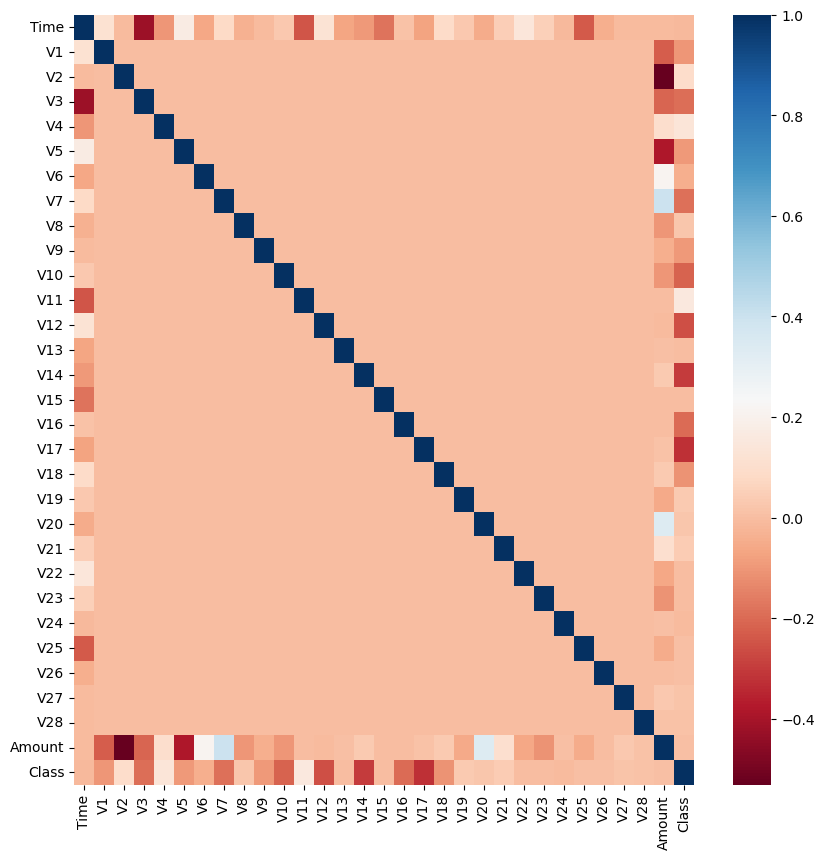

In [169]:
import seaborn as sns

plt.figure(figsize=(10,10))
corr = card_df.corr()
sns.heatmap(corr, cmap='RdBu')

In [170]:
import numpy as np

def get_outlier(df=None, column=None, weight=1.5):
    # fraud에 해당하는 column 데이터만 추출
    fraud = df[df['Class']==1][column]

    # 1/4 분위와 3/4 분위 지점을 np.percentile로 구함. 
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_75 = np.percentile(fraud.values, 75)

    # IQR을 구하고, IQR에 1.5를 곱하여 최대값과 최소값 지점 구함. 
    iqr = quantile_75 - quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight #lower
    highest_val = quantile_75 + iqr_weight #upper
    
    # 최대값 보다 크거나, 최소값 보다 작은 값을 아웃라이어로 설정하고 해당 이상치 데이터의 DataFrame index 반환. 
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    return outlier_index
    

In [171]:
outlier_index = get_outlier(df=card_df, column='V14', weight=1.5)
outlier_index

Int64Index([8296, 8615, 9035, 9252], dtype='int64')

In [172]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 인자로 입력받은 DataFrame을 복사 한 뒤 Time 컬럼만 삭제하고 복사된 DataFrame 반환
def get_preprocessed_df(df=None):
    df_copy = df.copy()
    df_copy.drop('Time', axis=1, inplace=True)
    
    #Amount scaling
    scaler = StandardScaler()
    amount_n = scaler.fit_transform(df_copy['Amount'].values.reshape(-1,1))
    df_copy.insert(0, 'Amount_scaled', amount_n)

    df_copy.drop(outlier_index, axis=0, inplace=True)
    
    return df_copy

### 이상치만 제거한 LR,LGBM 비교

In [173]:
# 이상치만 제거한 lr, lgbm 비교
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, X_train,X_test, y_train, y_test )
get_model_train_eval(lgbm_clf, X_train,X_test, y_train, y_test )

오차 행렬
[[85280    15]
 [   50    96]]
정확도: 0.9992, 정밀도: 0.8649, 재현율: 0.6575,    F1: 0.7471, AUC:0.9576
오차 행렬
[[85290     5]
 [   25   121]]
정확도: 0.9996, 정밀도: 0.9603, 재현율: 0.8288,    F1: 0.8897, AUC:0.9761


https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud/code

오차 행렬
[[85272    23]
 [   51    97]]
정확도: 0.9991, 정밀도: 0.8083, 재현율: 0.6554,    F1: 0.7239, AUC:0.9342

#V17 처리

### SMOTE - 오버샘플링 적용 후 모델 학습/예측/평가

로지스틱 회귀, LGBM 비교


In [174]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

In [175]:
# 학습 데이터에만 오버 샘플링 smote

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train,y_train)

print(f'X_train: {X_train.shape} y_train: {y_train.shape}')
print(f'X_train: {X_train_over.shape} y_train: {y_train_over.shape}')

X_train: (199362, 30) y_train: (199362,)
X_train: (398040, 30) y_train: (398040,)


In [176]:
print(f'y_train_over.value_counts():')
print(f'{pd.Series(y_train_over.value_counts())}')

y_train_over.value_counts():
0    199020
1    199020
Name: Class, dtype: int64


In [177]:
# 오버샘플링 후 lr, lgbm 재평가 : 
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, X_train_over,X_test, y_train_over, y_test )

from lightgbm import LGBMClassifier

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train_over, ftr_test=X_test, tgt_train=y_train_over, tgt_test=y_test)

오차 행렬
[[83471  1824]
 [   12   134]]
정확도: 0.9785, 정밀도: 0.0684, 재현율: 0.9178,    F1: 0.1274, AUC:0.9743
오차 행렬
[[85284    11]
 [   25   121]]
정확도: 0.9996, 정밀도: 0.9167, 재현율: 0.8288,    F1: 0.8705, AUC:0.9857


In [178]:
오차 행렬
[[85280    15]
 [   50    96]]
정확도: 0.9992, 정밀도: 0.8649, 재현율: 0.6575,    F1: 0.7471, AUC:0.9576
오차 행렬
[[85290     5]
 [   25   121]]
정확도: 0.9996, 정밀도: 0.9603, 재현율: 0.8288,    F1: 0.8897, AUC:0.9761

SyntaxError: invalid syntax (657401186.py, line 1)

로지스틱 회귀 \
1차 재현율,ROC-AUC 증가, 정확도 감소, 정밀도는 급격히 감소\
이유 : 오버샘플링된 클래스 데이터를 지나치게 적용했기 때문

LGBM\
1차 정확도,재현율 동일, ROC-AUC 증가 정밀도,F1 감소

In [41]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import precision_recall_curve
%matplotlib inline

def precision_recall_curve_plot(y_test , pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()

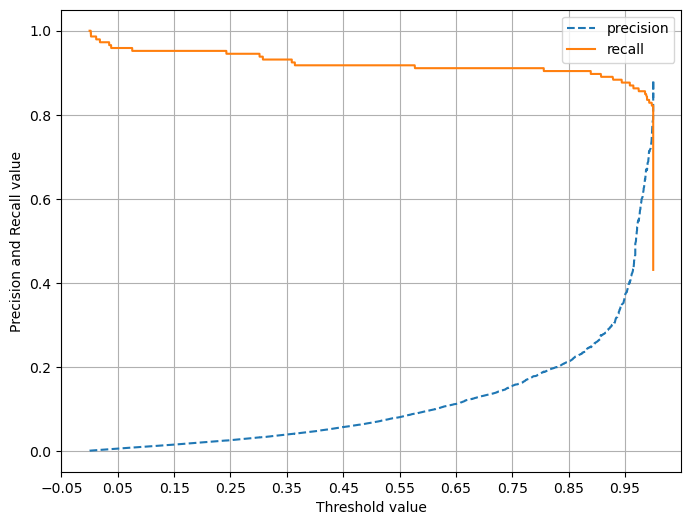

In [43]:
# LR의 SMOTE 적용 전 모델 성능
precision_recall_curve_plot(y_test,lr_clf.predict_proba(X_test)[:,1])

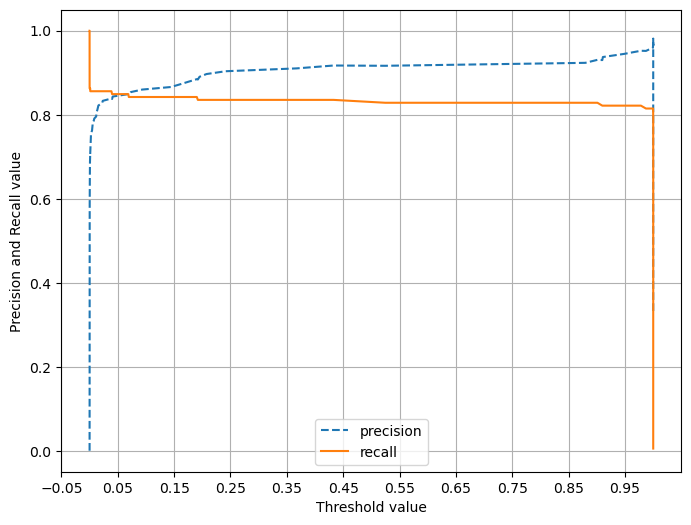

In [ ]:
# LR의 SMOTE 적용 후 모델 성능
precision_recall_curve_plot(y_test,lgbm_clf.predict_proba(X_test)[:,1])



1.
정확도: 0.9992, 정밀도: 0.8738, 재현율: 0.6081,    F1: 0.7171, AUC:0.9605 \
정확도: 0.9995, 정밀도: 0.9573, 재현율: 0.7568,    F1: 0.8453, AUC:0.9790

2.
정확도: 0.9992, 정밀도: 0.8598, 재현율: 0.6216,    F1: 0.7216, AUC:0.9653 \
정확도: 0.9995, 정밀도: 0.9573, 재현율: 0.7568,    F1: 0.8453, AUC:0.9812

3.
정확도: 0.9992, 정밀도: 0.8649, 재현율: 0.6575,    F1: 0.7471, AUC:0.9576 \
정확도: 0.9996, 정밀도: 0.9603, 재현율: 0.8288,    F1: 0.8897, AUC:0.9761

4.
정확도: 0.9785, 정밀도: 0.0684, 재현율: 0.9178,    F1: 0.1274, AUC:0.9743 \
정확도: 0.9996, 정밀도: 0.9167, 재현율: 0.8288,    F1: 0.8705, AUC:0.9857
